(sec-tune-algorithm-scheduler)=
# 超参数调优搜索算法和调度器

Ray Tune 的超参数搜索中比较重要的概念是搜索算法和调度器：搜索算法确定如何从搜索空间中选择新的超参数组合（即试验）；调度器决定对提前结束一些不太有前景的试验，节省计算资源。搜索算法是必须的，调度器不是必须的。这两者可以协作来选择超参数，比如使用随机搜索算法和异步连续减半算法（Async Successive Halving Algorithm，ASHA）调度器，调度器对一些看起来没希望的试验提前结束。另外，一些超参数优化的包通常提供了封装好的搜索算法，有的还提供了调度器，这些包有自己的使用方式和习惯，Ray Tune 对这些包进行了封装，尽量使得这些包的使用方式统一。下面简单介绍一些常见的搜索算法和调度器。

## Hyperband



In [1]:
import os
import tempfile

import sys
sys.path.append("..")
from utils import nyc_flights

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet18

import ray
from sklearn.model_selection import train_test_split
from ray.tune.search.hyperopt import HyperOptSearch
import xgboost as xgb
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.integration.xgboost import TuneReportCheckpointCallback
from ray.tune.schedulers import PopulationBasedTraining

folder_path = nyc_flights()
file_path = os.path.join(folder_path, "nyc-flights", "1991.csv")

读取数据，进行必要的数据预处理：

In [2]:
input_cols = [
    "Year",
    "Month",
    "DayofMonth",
    "DayOfWeek",
    "CRSDepTime",
    "CRSArrTime",
    "UniqueCarrier",
    "FlightNum",
    "ActualElapsedTime",
    "Origin",
    "Dest",
    "Distance",
    "Diverted",
    "ArrDelay",
]

df = pd.read_csv(file_path, usecols=input_cols,)

# 预测是否延误
df["ArrDelayBinary"] = 1.0 * (df["ArrDelay"] > 10)

df = df[df.columns.difference(["ArrDelay"])]

for col in df.select_dtypes(["object"]).columns:
    df[col] = df[col].astype("category").cat.codes.astype(np.int32)

for col in df.columns:
    df[col] = df[col].astype(np.float32)

XGBoost `train()` 函数的 `params` 参数接收树深度等超参数。需要注意的是，XGBoost 等训练框架提供的 `train()` 函数不像 PyTorch 那样有 `for epoch in range(...)` 这样的显式迭代训练过程，如果希望每次训练迭代后立即反馈性能指标，需要在 `train()` 的 `callbacks` 中传入回调函数，Ray 提供了 [`TuneReportCheckpointCallback`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.integration.xgboost.TuneReportCheckpointCallback.html)，这个回调函数会在每次训练迭代后将相关指标报告给 Ray Tune。具体到本例中，XGBoost 的 `train()` 函数的 `params` 参数传入了 `"eval_metric": ["logloss", "error"]`，表示评估时的指标； `evals=[(test_set, "eval")]` 表示只关注验证集的指标；以上两者合起来，表示对验证集计算 `logloss` 和 `error` 指标，汇报给 Ray Tune 时，指标名称为 `eval-logloss` 和 `eval-error`。

In [3]:
def train_flight(config: dict):
    config.update({
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"]
    })
    _y_label = "ArrDelayBinary"
    train_x, test_x, train_y, test_y = train_test_split(
        df.loc[:, df.columns != _y_label], 
        df[_y_label], 
        test_size=0.25
    )
    
    train_set = xgb.DMatrix(train_x, label=train_y)
    test_set = xgb.DMatrix(test_x, label=test_y)
    
    xgb.train(
        params=config,
        dtrain=train_set,
        evals=[(test_set, "eval")],
        verbose_eval=False,
        # 每次迭代后， `TuneReportCheckpointCallback` 将评估指标反馈给 Ray Tune
        callbacks=[TuneReportCheckpointCallback(frequency=1)]
    )

我们底层使用 `hyperopt` 包所提供的贝叶斯优化搜索算法，如果没安装这个包，请先安装：`pip install hyperopt`。这些包通常有自己的定义搜索空间格式，用户也可以直接使用 Ray Tune 提供的搜索空间定义方式。

调度器方面，我们使用 HyperBand 调度算法。[`AsyncHyperBandScheduler`](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.schedulers.AsyncHyperBandScheduler.html) 是 Ray Tune 推荐的 HyperBand 算法的实现，它是异步的，能够更充分利用计算资源。`AsyncHyperBandScheduler` 中 `time_attr` 是描述训练时间的单位，默认为 `training_iteration`，表示一次训练迭代周期，`time_attr` 是计算资源额度的基本时间单位。`AsyncHyperBandScheduler` 的其他参数与 `time_attr` 规定的时间单位高度相关，比如 `max_t` 是每个试验所能获得的总时间，即一个试验最多能获得 `max_t` * `time_attr` 的计算资源额度；`grace_period` 表示至少给每个试验 `grace_period` * `time_attr` 的计算资源额度。`reduction_factor` 是上述数学描述中的 $\eta$，`brackets` 为 HyperBand 算法所涉及的组合的概念。

In [4]:
search_space = {
    "max_depth": tune.randint(1, 9),
    "min_child_weight": tune.choice([1, 2, 3]),
    "subsample": tune.uniform(0.5, 1.0),
    "eta": tune.loguniform(1e-4, 1e-1),
}

scheduler = AsyncHyperBandScheduler(
    max_t=10,
    grace_period=1,
    reduction_factor=2,
    brackets=3,
)

tuner = tune.Tuner(
    train_flight,
    tune_config=tune.TuneConfig(
        metric="eval-error",
        mode="min",
        scheduler=scheduler,
        num_samples=16,
    ),
    param_space=search_space,
)
results = tuner.fit()

(raylet) Warning: The actor ImplicitFunc is very large (27 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(train_flight pid=46796) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/u20200002/ray_results/train_flight_2024-04-17_23-23-05/train_flight_63737_00004_4_eta=0.0697,max_depth=1,min_child_weight=2,subsample=0.9087_2024-04-17_23-23-08/checkpoint_000000)
2024-04-17 23:23:16,344	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/u20200002/ray_results/train_flight_2024-04-17_23-23-05' in 0.0653s.
2024-04-17 23:23:16,362	INFO tune.py:1048 -- Total run time: 10.73 seconds (10.38 seconds for the tuning loop).


`Tuner.fit()` 会将所有试验的结果返回成 `ResultGrid` ，也会把各类信息写到持久化存储上，用户可以查看不同超参数下的效果并进行分析和对比：

In [5]:
def get_best_model_checkpoint(results):
    best_result = results.get_best_result()

    # `TuneReportCheckpointCallback` 提供了从最优结果中返回 Checkpoint 的方法
    best_bst = TuneReportCheckpointCallback.get_model(best_result.checkpoint)

    accuracy = 1.0 - best_result.metrics["eval-error"]
    print(f"Best model parameters: {best_result.config}")
    print(f"Best model total accuracy: {accuracy:.4f}")
    return best_bst

best_bst = get_best_model_checkpoint(results)

Best model parameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8249317015751376, 'eta': 0.08070421841931029, 'objective': 'binary:logistic', 'eval_metric': ['logloss', 'error']}
Best model total accuracy: 0.8235


In [6]:
results_df = results.get_dataframe()
results_df[["eval-error", "training_iteration", "config/max_depth", "config/min_child_weight", "config/subsample"]]

,eval-error,training_iteration,config/max_depth,config/min_child_weight,config/subsample
0,0.222878,10,2,3,0.963344
1,0.219595,10,3,3,0.930057
2,0.223699,1,3,1,0.532473
3,0.176524,10,7,1,0.824932
4,0.223466,10,1,2,0.908686
5,0.223869,10,4,2,0.799064
6,0.221360,2,5,2,0.555629
7,0.223079,1,8,3,0.842890
8,0.221159,2,5,1,0.766606
9,0.223745,2,2,3,0.576874


### 案例：基于 PBT 进行图像分类

PBT 在训练过程中会对模型权重和超参数都进行调整，因此其训练代码部分必须有更新（加载）模型权重的代码。另外一个区别是训练迭代部分，大部分 PyTorch 训练过程都有 `for epoch in range(...)` 这样显式定义迭代训练的循环，循环一般有终止条件；PBT 训练过程不设置终止条件，当模型指标达到预期或者需要早停，Ray Tune 终止，因此训练迭代处使用 `while True` 一直循环迭代，直到被 Ray Tune 终止。

In [ ]:
data_dir = os.path.join(os.getcwd(), "../data")

def train_func(model, optimizer, criterion, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [13]:
def train_mnist(config):
    step = 1
    transform = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), 
         torchvision.transforms.Normalize((0.5,), (0.5,))]
    )

    train_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform),
        batch_size=128,
        shuffle=True)
    test_loader = DataLoader(
        torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform),
        batch_size=128,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
    )
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=config.get("lr", 0.01), 
        momentum=config.get("momentum", 0.9)
    )

    checkpoint = ray.train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
        
        model.load_state_dict(checkpoint_dict["model_state_dict"])
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        
        # 将 config 传进来的 lr 和 momentum 更新到优化器中 
        for param_group in optimizer.param_groups:
            if "lr" in config:
                param_group["lr"] = config["lr"]
            if "momentum" in config:
                param_group["momentum"] = config["momentum"]
        
        last_step = checkpoint_dict["step"]
        step = last_step + 1
    
    # Ray Tune 会根据性能指标终止试验
    while True:
        train_func(model, optimizer, criterion, train_loader)
        acc = test_func(model, test_loader)
        metrics = {"mean_accuracy": acc, "lr": config["lr"]}

        if step % config["checkpoint_interval"] == 0:
            with tempfile.TemporaryDirectory() as tmpdir:
                torch.save(
                    {
                        "step": step,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                    },
                    os.path.join(tmpdir, "checkpoint.pt"),
                )
                ray.train.report(metrics, checkpoint=ray.train.Checkpoint.from_directory(tmpdir))
        else:
            ray.train.report(metrics)

        step += 1

接下来使用 [PopulationBasedTraining](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.schedulers.PopulationBasedTraining.html) 定义 PBT 调度器。`time_attr` 跟刚才提到的其他调度器一样，是一个时间单位。`perturbation_interval` 表示每隔一定时间对超参数进行一些变异扰动，生成新的超参数，通常与 `checkpoint_interval` 使用同一个值，因为超参数变异扰动的同时也将 Checkpoint 写入持久化存储，会带来额外的开销，因此这个值不宜设置得过频繁。PBT 算法从 `hyperparam_mutations` 里选择可能变异的值，`hyperparam_mutations` 是一个键值字典，里面的内容就是变异值。

In [14]:
perturbation_interval = 5
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=perturbation_interval,
    metric="mean_accuracy",
    mode="max",
    hyperparam_mutations={
        "lr": tune.uniform(0.0001, 1),
        "momentum": [0.8, 0.9, 0.99],
    },
)

接下来就可以进行训练了。我们需要给 PBT 设置停止的条件，本例是 `mean_accuracy` 达到 0.9 或一共完成 20 次迭代。

In [16]:
tuner = tune.Tuner(
    tune.with_resources(train_mnist, {"gpu": 1}),
    run_config=ray.train.RunConfig(
        name="pbt_mnist",
        # 停止条件：`stop` 或者 `training_iteration` 两个条件任一先达到
        stop={"mean_accuracy": 0.9, "training_iteration": 20},
        checkpoint_config=ray.train.CheckpointConfig(
            checkpoint_score_attribute="mean_accuracy",
            num_to_keep=4,
        ),
        storage_path="~/ray_results",
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=4,
    ),
    param_space={
        "lr": tune.uniform(0.001, 1),
        "momentum": tune.uniform(0.001, 1),
        "checkpoint_interval": perturbation_interval,
    },
)

results_grid = tuner.fit()

2024-04-17 18:03:53,880	INFO pbt.py:716 -- [pbt]: no checkpoint for trial train_mnist_817a7_00003. Skip exploit for Trial train_mnist_817a7_00001
2024-04-17 18:09:24,486	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-17 18:09:24,492	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/u20200002/ray_results/pbt_mnist' in 0.0111s.
2024-04-17 18:09:24,501	INFO tune.py:1048 -- Total run time: 455.82 seconds (455.74 seconds for the 

调优之后，就可以查看不同超参数的结果了，我们选择最优的那个结果，查看 `lr` 的变化过程。

Best result path: /home/u20200002/ray_results/pbt_mnist/train_mnist_817a7_00003_3_lr=0.1277,momentum=0.4868_2024-04-17_18-01-48
Best final iteration hyperparameter config:
 {'lr': 0.1277359940819796, 'momentum': 0.48679312797681595, 'checkpoint_interval': 5}


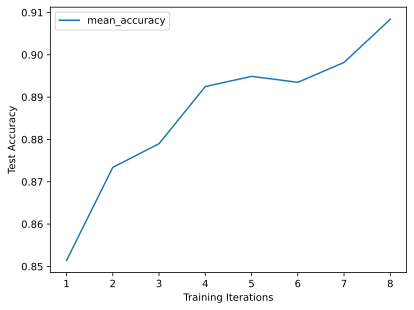

In [18]:
%config InlineBackend.figure_format = 'svg'

best_result = results_grid.get_best_result(metric="mean_accuracy", mode="max")

print('Best result path:', best_result.path)
print("Best final iteration hyperparameter config:\n", best_result.config)

df = best_result.metrics_dataframe
df = df.drop_duplicates(subset="training_iteration", keep="last")
df.plot("training_iteration", "mean_accuracy")
plt.xlabel("Training Iterations")
plt.ylabel("Test Accuracy")
plt.show()